In [26]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [77]:
import torch

def generate_time_series_features_pytorch(n_samples, n_features, n_steps=100, noise_level=0.01):
    """
    Generates a synthetic time series dataset with n_samples and n_features using PyTorch.
    
    Parameters:
    - n_samples: int, the number of samples to generate.
    - n_features: int, the number of features (time series) to generate for each sample.
    - n_steps: int, the number of time steps for each feature.
    - noise_level: float, the level of noise to add to the time series.
    
    Returns:
    - A tuple of PyTorch tensors: (features, target) where
      features is of shape (n_samples, n_steps, n_features) representing the generated time series data,
      and target is a tensor for the target variable.
    """
    # Time axis for the sine wave
    time = torch.linspace(0, 2 * torch.pi, n_steps)
    
    # Generate sine waves for each feature and sample
    features = torch.stack([torch.stack([torch.sin(time + 4*torch.rand(1) * 2 * torch.pi) for _ in range(n_samples)]).T for _ in range(n_features)], dim=2).permute(1, 0, 2)    
    # Add noise
    features += torch.randn(features.shape) * noise_level
    
    # Example target calculation (modify according to your needs)
    # Calcul de la cible en combinant les caractéristiques
    # Exemple : une combinaison linéaire des caractéristiques avec des poids arbitraires
    weights = torch.tensor([0.4, 0.2, 0.4])  # Poids pour 3 caractéristiques, ajustez selon le nombre de caractéristiques
    if n_features >= 3:
        target = features[:, 5, 0] * weights[0] * features[:, 10, 1] * weights[1] + features[:, -10, 2] + weights[2]
        #la target sera simplement la valeur finale du vecteur target
    else:
        # Si moins de 3 caractéristiques, utilisez une logique différente ou ajustez les poids
        target = features[:, :, 0]  # Fallback simple si moins de 3 caractéristiques

    return features, target

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn as nn


class TransformerModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, nhead):
        super(TransformerModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.input_dim = input_dim

        # Define a linear layer to transform input to embedding dimension
        self.input_linear = nn.Linear(input_dim, hidden_dim)
        
        # Positional encoding to add position information to the input embeddings
        self.positional_encoding = nn.Parameter(torch.zeros(1, 5000, hidden_dim))

        # Define the Transformer encoder layer
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Define the output linear layer
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x shape: [batch_size, seq_len, input_dim]
        
        # Apply linear transformation to input to get embeddings
        x = self.input_linear(x)
        
        # Add positional encoding
        seq_len = x.size(1)
        x += self.positional_encoding[:, :seq_len, :]

        # Transformer expects input of shape [seq_len, batch_size, hidden_dim]
        x = x.transpose(0, 1)
        
        # Pass through the transformer encoder
        transformer_out = self.transformer_encoder(x)
        
        # Select the last time step's output
        last_time_step = transformer_out[-1, :, :]

        # Pass through the final linear layer to get predictions
        y_pred = self.linear(last_time_step)
        return y_pred


In [34]:
# Initialisation du modèle
input_dim = 3
hidden_dim = 64
output_dim = 1
num_layers = 3
nhead = 8

model = TransformerModel(input_dim, hidden_dim, output_dim, num_layers, nhead)

# Préparation des données d'entrée
x = torch.randn(32, 20, input_dim)  # batch_size = 32, seq_len = 20, input_dim = 3

# Passage des données à travers le modèle
y_pred = model(x)

# Vérification de la sortie
print(y_pred.shape)  # Doit afficher torch.Size([32, 1]), correspondant à [batch_size, output_dim]

torch.Size([32, 1])


Text(0, 0.5, 'Value')

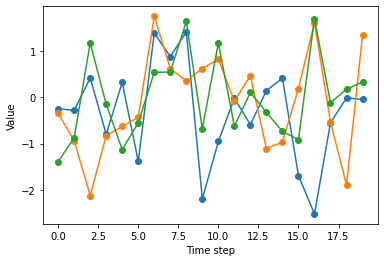

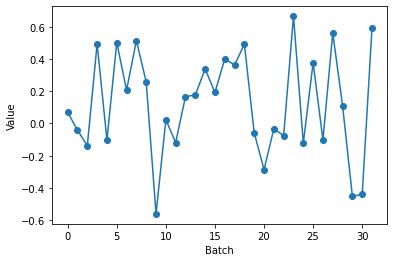

In [36]:
#plot the input data x 
fig, ax = plt.subplots()
c = ax.plot(x[0, :, :].detach().numpy(), '-o')
ax.set_xlabel('Time step')
ax.set_ylabel('Value')

#plot the output data y_pred
fig, ax = plt.subplots()
c = ax.plot(y_pred.detach().numpy(), '-o')
ax.set_xlabel('Batch')
ax.set_ylabel('Value')


### Modification to get the attention mask

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class CustomTransformerEncoderLayer(nn.TransformerEncoderLayer):
    def __init__(self, *args, **kwargs):
        super(CustomTransformerEncoderLayer, self).__init__(*args, **kwargs)
        self.self_attn_weights = None

    def forward(self, src, src_mask=None, src_key_padding_mask=None, is_causal=False):
        src2 = self.self_attn(src, src, src, attn_mask=src_mask, key_padding_mask=src_key_padding_mask)[0]
        self.self_attn_weights = self.self_attn(src, src, src, attn_mask=src_mask, key_padding_mask=src_key_padding_mask)[1]
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src

class TransformerModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, nhead):
        super(TransformerModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.input_dim = input_dim

        # Define a linear layer to transform input to embedding dimension
        self.input_linear = nn.Linear(input_dim, hidden_dim)
        
        # Positional encoding to add position information to the input embeddings
        self.positional_encoding = nn.Parameter(torch.zeros(1, 5000, hidden_dim))

        # Define the Transformer encoder layer
        encoder_layer = CustomTransformerEncoderLayer(d_model=hidden_dim, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Define the output linear layer
        self.linear = nn.Linear(hidden_dim, output_dim)
        
        self.attention_weights = None

    def forward(self, x):
        # x shape: [batch_size, seq_len, input_dim]
        
        # Apply linear transformation to input to get embeddings
        x = self.input_linear(x)
        
        # Add positional encoding
        seq_len = x.size(1)
        x += self.positional_encoding[:, :seq_len, :]

        # Transformer expects input of shape [seq_len, batch_size, hidden_dim]
        x = x.transpose(0, 1)
        
        # Pass through the transformer encoder
        transformer_out = self.transformer_encoder(x)
        
        # Select the last time step's output
        last_time_step = transformer_out[-1, :, :]

        # Pass through the final linear layer to get predictions
        y_pred = self.linear(last_time_step)
        
        # Store attention weights
        self.attention_weights = [layer.self_attn_weights for layer in self.transformer_encoder.layers]
        
        return y_pred

    def get_attention_weights(self):
        return self.attention_weights




In [204]:
# Example usage
input_dim = 3
hidden_dim = 8
output_dim = 1
num_layers = 3
nhead = 4

model = TransformerModel(input_dim, hidden_dim, output_dim, num_layers, nhead)
# Dummy input
x = torch.rand(32, 20, input_dim)  # batch_size=32, seq_len=100, input_dim=10
y_pred = model(x)

# Get attention weights
attention_weights = model.get_attention_weights()


In [205]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np

In [206]:
def split_data(features_normalized, target_normalized, device, test_size=0.2):
    features_train, features_test, target_train, target_test = train_test_split(
    features_normalized, target_normalized, test_size=test_size, random_state=42)

    # Convertir en tenseurs PyTorch et envoyer au dispositif approprié
    features_train_tensor = torch.tensor(features_train, dtype=torch.float).to(device)
    target_train_tensor = torch.tensor(target_train, dtype=torch.float).to(device)
    features_test_tensor = torch.tensor(features_test, dtype=torch.float).to(device)
    target_test_tensor = torch.tensor(target_test, dtype=torch.float).to(device)
    return features_train_tensor, target_train_tensor, features_test_tensor, target_test_tensor

In [207]:
features, target = generate_time_series_features_pytorch(n_features=3, n_steps=30, noise_level=0.05, n_samples=600)

scaler = StandardScaler()
num_samples, num_time_steps, num_features = features.shape
features_reshaped = features.reshape(-1, num_features)
scaler.fit(features_reshaped)  # Fit sur l'ensemble d'entraînement

# Appliquer la normalisation
features_normalized = scaler.transform(features_reshaped)
features_normalized = features_normalized.reshape(num_samples, num_time_steps, num_features)

target_scaler = MinMaxScaler(feature_range=(0, 1))
target_2d = target.reshape(-1, 1)

# Adapter le scaler à la cible redimensionnée
target_scaler.fit(target_2d)
target_normalized = target_scaler.transform(target_2d)

In [208]:
model = TransformerModel(input_dim, hidden_dim, output_dim, num_layers, nhead)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

c:\Users\Mehdi\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [209]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [210]:

def train_model(model, optimizer, criterion, features_train_tensor, target_train_tensor, features_test_tensor, target_test_tensor, n_epochs=300, patience=100):
    best_loss = np.inf
    epochs_no_improve = 0
    loss_save = []
    r2_save = {}
    best_r2 = float('-inf')
    epochs_no_improve_r2 = 0

    for epoch in range(n_epochs):
        model.train()
        optimizer.zero_grad()
        y_pred = model(features_train_tensor)
        loss = criterion(y_pred, target_train_tensor)
        loss.backward()
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            y_val_pred = model(features_test_tensor)
            val_loss = criterion(y_val_pred, target_test_tensor)
            # Calcul du R² sur l'ensemble de validation
            r2_val = 1 - val_loss / torch.var(target_test_tensor)
            r2_train = 1 - loss / torch.var(target_train_tensor)

        # Vérifier si le R² de validation s'est amélioré de 0.01
        if torch.abs(r2_val - best_r2) > 0.01:
            best_r2 = r2_val
            epochs_no_improve_r2 = 0
            print(f'Epoch {epoch + 1}, Improved R²: {best_r2.item()}')
        else:
            epochs_no_improve_r2 += 1
            if epochs_no_improve_r2 == patience:
                print(f'Early stopping! Epoch {epoch + 1}, Best R²: {best_r2.item()}')
                break  # Arrêt anticipé

        # Optionnel: Enregistrer la perte d'entraînement pour visualisation
        loss_save.append(loss.item())
        r2_save[epoch] = {'train_loss': loss.item(), 'val_loss': val_loss.item(), 'r2': r2_val.item(),
                            'train_r2': r2_train.item()}

    # Visualisation de la perte d'entraînement
    fig, (ax, ax2) = plt.subplots(1, 2, figsize=(20, 5))
    ax.plot(loss_save, label='Training Loss', color='blue')
    ax.plot([x['val_loss'] for x in r2_save.values()], label='Validation Loss', color='red')
    #log scale y axis
    ax.set_yscale('log')
    ax.set_title('Training Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    ax2.plot([x['r2'] for x in r2_save.values()], label='R² test', color='green')
    ax2.plot([x['train_r2'] for x in r2_save.values()], label='R² train', color='blue')
    ax2.legend()
    ax2.set_title('R² Score')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('R²')
    #ax2 between 0 and 1
    ax2.set_ylim(0, 1)
    plt.show()

    return model

In [211]:

# 4. Convertissez vos données en tenseurs PyTorch et déplacez-les sur le GPU
model.to(device)
features_tensor = torch.tensor(features_normalized, dtype=torch.float32).to(device)
target_tensor = torch.tensor(target_normalized, dtype=torch.float32).to(device)

# 5. Divisez les données en ensembles d'entraînement et de test
features_train_tensor, target_train_tensor, features_test_tensor, target_test_tensor = split_data(features_normalized, target_normalized, device)


Epoch 1, Improved R²: 0.14983993768692017
Epoch 6, Improved R²: 0.13959133625030518
Epoch 10, Improved R²: 0.14985054731369019
Epoch 24, Improved R²: 0.1627846360206604
Epoch 31, Improved R²: 0.17400598526000977
Epoch 46, Improved R²: 0.187904953956604
Epoch 48, Improved R²: 0.2044035792350769
Epoch 50, Improved R²: 0.21581107378005981
Epoch 52, Improved R²: 0.23145592212677002
Epoch 53, Improved R²: 0.24310576915740967
Epoch 55, Improved R²: 0.2595445513725281
Epoch 57, Improved R²: 0.2747783660888672
Epoch 58, Improved R²: 0.2899121046066284
Epoch 59, Improved R²: 0.3062326908111572
Epoch 60, Improved R²: 0.3192189931869507
Epoch 61, Improved R²: 0.3337615132331848
Epoch 62, Improved R²: 0.36440032720565796
Epoch 63, Improved R²: 0.3942420482635498
Epoch 64, Improved R²: 0.42187976837158203
Epoch 65, Improved R²: 0.4502268433570862
Epoch 66, Improved R²: 0.4901953339576721
Epoch 67, Improved R²: 0.5220524668693542
Epoch 68, Improved R²: 0.5648362636566162
Epoch 69, Improved R²: 0.607

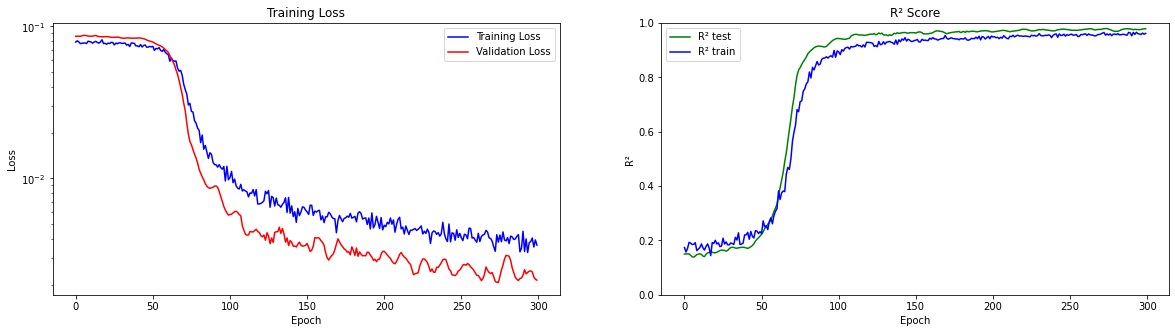

In [217]:
#train model 
model = train_model(model, optimizer, criterion, features_train_tensor, target_train_tensor, features_test_tensor, target_test_tensor, n_epochs=300, patience=100)

In [218]:
# Passage en mode évaluation
model.eval()

with torch.no_grad():  # Assurez-vous qu'aucun gradient n'est calculé
    predictions_test = model(features_test_tensor)
    predictions_train = model(features_train_tensor)

# Calcul de l'erreur quadratique moyenne (MSE) sur l'ensemble de test
mse_test = torch.mean((predictions_test - target_test_tensor) ** 2)
print(f'MSE sur l\'ensemble de test: {mse_test.item()}')

# Calcul du R² sur l'ensemble de test
r2_test = 1 - mse_test / torch.var(target_test_tensor)
print(f'R² sur l\'ensemble de test: {r2_test.item()}')

MSE sur l'ensemble de test: 0.002144393278285861
R² sur l'ensemble de test: 0.9788604378700256


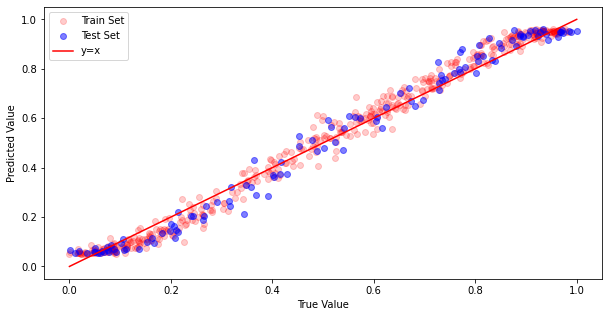

In [219]:
import matplotlib.pyplot as plt

# Conversion des prédictions et des vraies valeurs en CPU pour l'affichage
predictions_np = predictions_test.cpu().numpy()
target_np = target_test_tensor.cpu().numpy()

prediction_train_np = predictions_train.cpu().numpy()
target_train_np = target_train_tensor.cpu().numpy()

# Affichage des prédictions vs les vraies valeurs
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(target_train_np, prediction_train_np, alpha=0.2, label='Train Set', color='red')
ax.scatter(target_np, predictions_np, alpha=0.5, label='Test Set', color='blue')
ax.set_xlabel('True Value')
ax.set_ylabel('Predicted Value')
#add y = x line 
x = np.linspace(0, 1, 100)
y = x
ax.plot(x, y, '-r', label='y=x')
ax.legend()

the target is 0.7650507092475891
the key features are -0.7873919010162354, 0.3279767334461212, 0.38571038842201233
recalcul of the target using the key features
the recalculated target is 0.7650507092475891


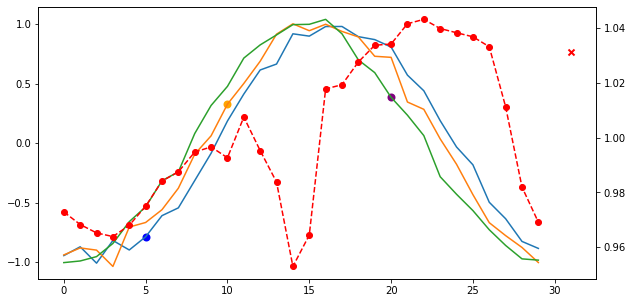

In [225]:
sample_id = 5

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for i in range(features.shape[2]):
    ax.plot(features[sample_id, :, i], label=f'Feature {i+1}')
    #display the target
ax.scatter(31, target[sample_id], label='Target', linewidth=2, color='red', marker='x')
    
print(f'the target is {target[sample_id]}')
print(f'the key features are {features[sample_id, 5, 0]}, {features[sample_id, 10, 1]}, {features[sample_id, -10, 2]}')

print('recalcul of the target using the key features')
weights = torch.tensor([0.4, 0.2, 0.4])  # Poids pour 3 caractéristiques, ajustez selon le nombre de caractéristiques
recalculated_target = features[sample_id, 5, 0] * weights[0] * features[sample_id, 10, 1] * weights[1] + features[sample_id, -10, 2] + weights[2]
print(f'the recalculated target is {recalculated_target}')

#plot the key features
ax.scatter(5, features[sample_id, 5, 0], label='Feature 1', linewidth=2, color='blue', marker='o')
ax.scatter(10, features[sample_id, 10, 1], label='Feature 2', linewidth=2, color='orange', marker='o')
ax.scatter(20, features[sample_id, -10, 2], label='Feature 3', linewidth=2, color='purple', marker='o')

#add the attention sum 
ax2 = ax.twinx()
final_attention = attention_weights[-1].detach().cpu().numpy()[sample_id, :, :]
sum_attention = final_attention.sum(axis=0)
c = ax2.plot(sum_attention, '--o', color='red', label='Attention sum')

3


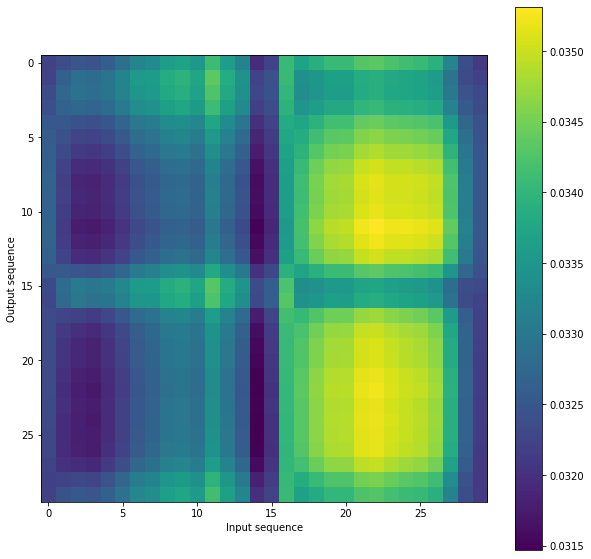

In [226]:
# Get attention weights
attention_weights = model.get_attention_weights()
print(len(attention_weights))  # Doit afficher 2, correspondant au nombre de couches dans le modèle
fig, ax = plt.subplots(figsize=(10, 10))
c = ax.imshow(attention_weights[-1].detach().cpu().numpy()[sample_id, :, :])
final_attention = attention_weights[-1].detach().cpu().numpy()[sample_id, :, :]
ax.set_xlabel('Input sequence')
ax.set_ylabel('Output sequence')
plt.colorbar(c)